# ハイパーパラメータの最適化

* ハイパーパラメータの「良い値」を徐々に絞り込んでいく。
* 具体的には、おおまかに、0.001 ($10^-3) から 1,000 ($10^3$) といったように、10の階乗のスケールで指定する。

1. ハイパーパラメータの範囲を設定する
2. ハイパーパラメータの範囲からランダムにサンプリングする
3. 学習を行い、検証データで認識精度を評価する（エポックは小さく設定）
4. ステップ1と2をある回数（100回など）繰り返し、認識精度の結果からハイパーパラメータの範囲を狭める。

In [1]:
# ライブラリの読み込み
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

In [2]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True)

print('x_train:', x_train.shape) # 6万件のデータ、784 (28x28を1次元に変換)
print('y_train:', y_train.shape) # 6万件のデータ、正解ラベル(0〜9)

x_train: (60000, 784)
y_train: (60000,)


In [3]:
# 高速化のため訓練データの削減
x_train = x_train[:500]  # 500件のみ取得
y_train = y_train[:500]

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)

x_train: (500, 784)
y_train: (500,)


In [4]:
# CVデータの作成
cv_rate              = 0.20
cv_num              = x_train.shape[0] * cv_rate # 100件 (500件 x 0.2)
x_train, y_train = shuffle_dataset(x_train, y_train) # データをシャッフル
x_cv, y_cv         = x_train[:cv_num], y_train[:cv_num] # cvデータの取得
x_train, y_train = x_train[cv_num:], y_train[cv_num:] # trainデータの取得

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_cv    :', x_cv.shape)
print('y_cv    :', y_cv.shape)

x_train: (400, 784)
y_train: (400,)
x_cv    : (100, 784)
y_cv    : (100,)


/Users/yanagi/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/yanagi/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
# トレーニングメソッド
def __train(lr, weight_decay, epocs=50):
    """
    lr : 学習率(learning rate)
    weight_decay : 正規項のλの値
    epocs : バッチ
    """
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100,100, 100, 100],
                                                output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, y_train, x_cv, y_cv,
                                 epochs=epocs, mini_batch_size=100,
                                 optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()
    return trainer.test_acc_list, trainer.train_acc_list

In [7]:
# ハイパーパラメータのランダム探索
optimization_trial = 100
results_cv = {}
results_train = {}

for _ in range(optimization_trial):
    # 探索したいハイパーパラメータの範囲をランダムで指定
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    
    # ランダムなパラメータでトレーニング
    cv_acc_list, train_acc_list = __train(lr, weight_decay)
    print('cv accuracy:' + str(cv_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_cv[key]     = cv_acc_list
    results_train[key] = train_acc_list
    print('Finish')

cv accuracy:0.11 | lr:1.9708130426921188e-05, weight decay:5.1650722879310695e-06
cv accuracy:0.13 | lr:0.0017823633030430782, weight decay:3.848801104203354e-07
cv accuracy:0.09 | lr:1.6866901559277443e-05, weight decay:5.616464190770207e-06
cv accuracy:0.13 | lr:6.6414328650935766e-06, weight decay:1.4894846392535072e-08
cv accuracy:0.18 | lr:0.00014026757155303438, weight decay:3.2036264647804874e-05
cv accuracy:0.05 | lr:3.0238031217356832e-06, weight decay:1.4968468742792841e-06
cv accuracy:0.05 | lr:7.910011434863905e-05, weight decay:1.5063571502236083e-06
cv accuracy:0.07 | lr:0.00066014291624058, weight decay:5.553910616378119e-06
cv accuracy:0.13 | lr:1.014025450403426e-06, weight decay:3.3430143410240988e-06
cv accuracy:0.15 | lr:2.7019031935617454e-06, weight decay:1.1742670783955888e-08
cv accuracy:0.22 | lr:0.0007499221700241048, weight decay:4.8797568620319796e-05
cv accuracy:0.34 | lr:0.0009236079414492503, weight decay:1.060244129067191e-05
cv accuracy:0.68 | lr:0.0055

Best-1(cv acc:0.8) | lr:0.006550674155157413, weight decay:1.3484749555605037e-05
Best-2(cv acc:0.79) | lr:0.007152594173578743, weight decay:3.1853758831904187e-07
Best-3(cv acc:0.73) | lr:0.007131948712066343, weight decay:8.81608354312839e-07
Best-4(cv acc:0.72) | lr:0.006012500410472603, weight decay:7.493941471957179e-05
Best-5(cv acc:0.71) | lr:0.008404767331898747, weight decay:9.110343809824868e-05


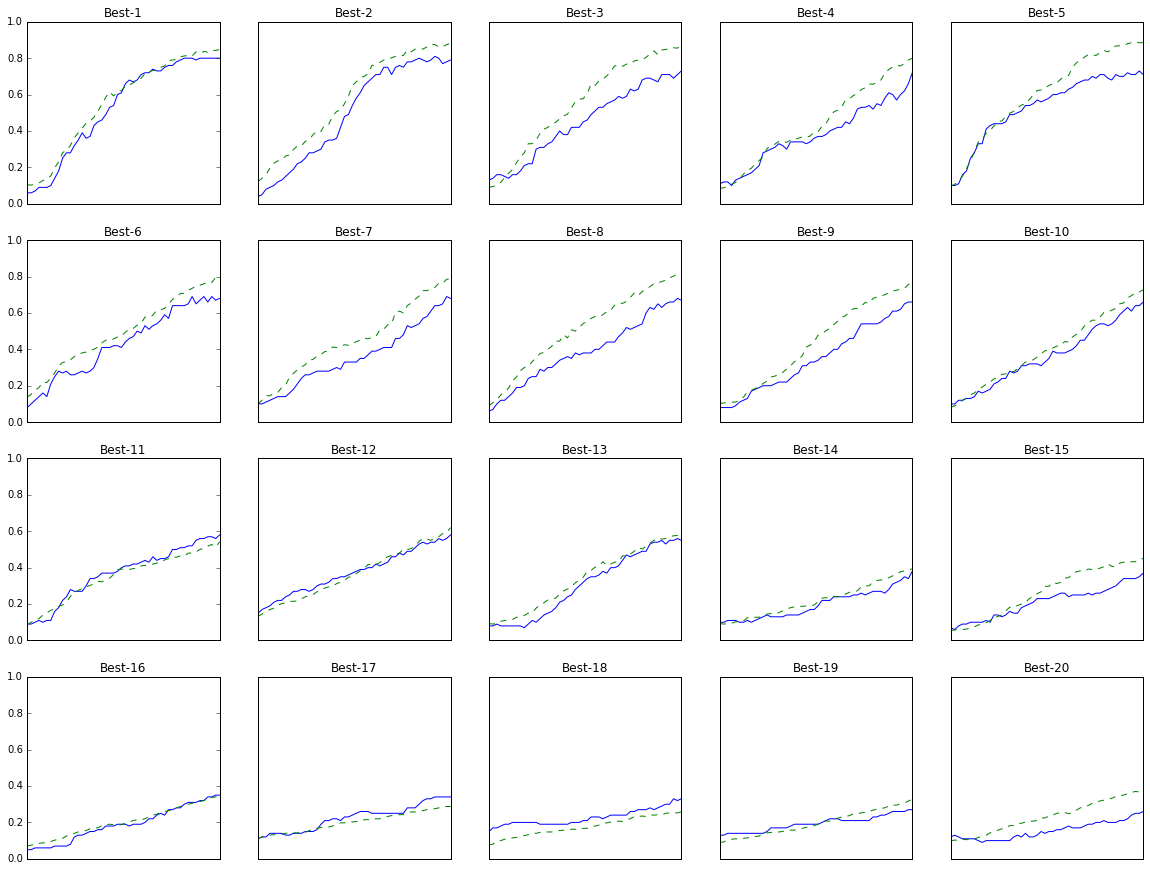

In [26]:
# グラフの描画
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(20,15))
for key, cv_acc_list in sorted(results_cv.items(), key=lambda x:x[1][-1], reverse=True):
    if i < 5:
        print("Best-" +  str(i+1) + "(cv acc:" + str(cv_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(cv_acc_list))
    plt.plot(x, cv_acc_list)
    plt.plot(x, results_train[key], '--')
    i += 1
    
    if i >= graph_draw_num:
        break
        
plt.show()